In [ ]:

import tensorflow_datasets as tfds

import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from glob import glob

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

###데이터준비

In [ ]:
#데이터 로드(불러오기)

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#압축 풀어주기

%cd /content/drive/MyDrive/종설/New_sample #압축을 풀 경로

!unzip -qq "/content/drive/MyDrive/종설/New_sample.zip"

In [ ]:
#이미지 경로를 데이터 프레임 형태로 만드는 함수

#dir_ = Path('/content/drive/MyDrive/종설/New_sample/원천데이터/01.가지')
dir_ = Path('/content/drive/MyDrive/종설/New_sample')

#filepaths = list(dir_.glob(r'**/*.json'))#############라벨링
filepaths = list(dir_.glob(r'**/*.jpg'))#############원천데이터

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/종설/New_sample/원천데ᄋ...,1.diseased
1,/content/drive/MyDrive/종설/New_sample/원천데ᄋ...,1.diseased
2,/content/drive/MyDrive/종설/New_sample/원천데ᄋ...,0.healthy
3,/content/drive/MyDrive/종설/New_sample/원천데ᄋ...,0.healthy
4,/content/drive/MyDrive/종설/New_sample/원천데ᄋ...,0.healthy


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 194

Number of different labels: 2

Labels: ['1.diseased' '0.healthy']


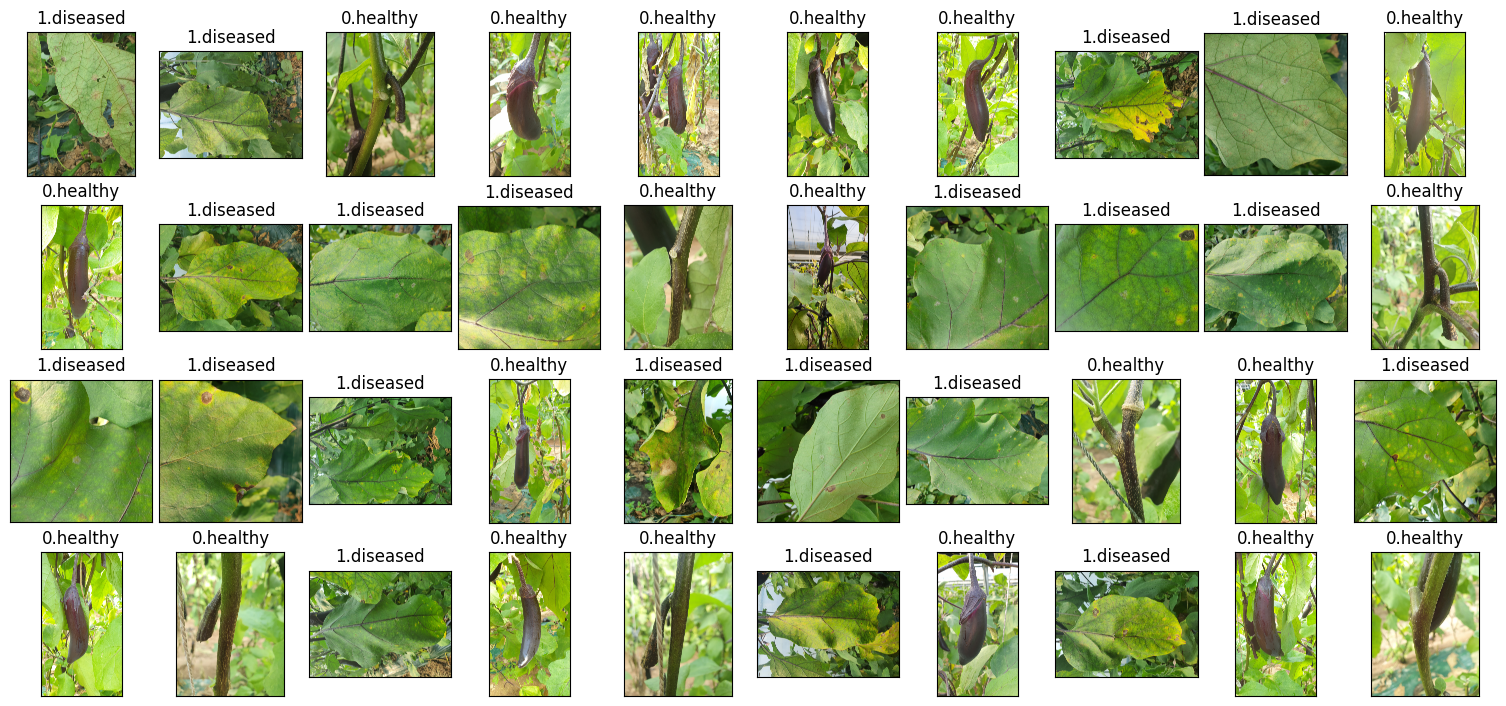

In [ ]:
#이미지 데이터 확인
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  #img=plt.imread(df.Filepath[i])
  #ax.imshow(img)
  ax.imshow(plt.imread(df.Filepath[i]))
  ax.set_title(df.Label[i], fontsize = 12)

plt.tight_layout(pad=0.5)
plt.show()

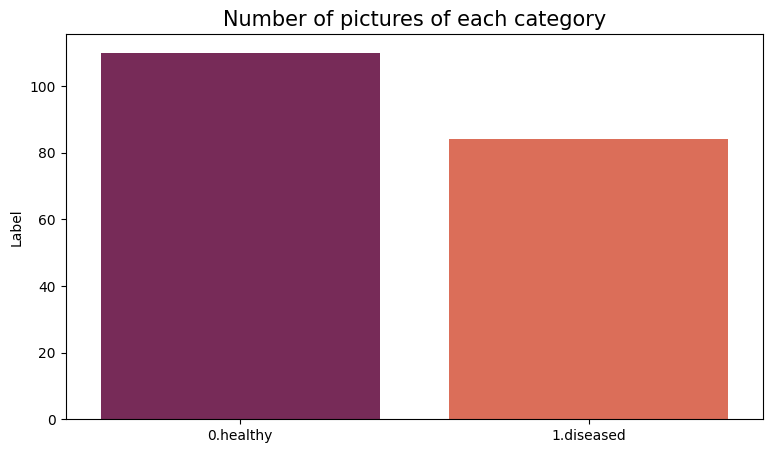

In [ ]:
#Label Category 분포 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
#이미지 데이터를 Train, Test 데이터로 분류

# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((174, 2), (20, 2))

###모델 전처리

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

#이미지증식 함수 활용. rescale=1./255: 값을 0과 1사이로 변경, validation_split
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, horizontal_flip=True,
                                   validation_split=0.1)

#validation_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.15)

train_data_dir= '/content/drive/MyDrive/종설/New_sample'

train_gen = train_datagen.flow_from_directory(train_data_dir,
                                                 #target_size = (3024, 4032),
                                                 target_size = (224, 224),

                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory(train_data_dir,
                                                 #target_size = (3024, 4032),
                                                 target_size = (224, 224),

                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')
'''
kefar.Sequential._fit_generator(
    train_gen,
    steps_per_epoch=train_gen.samples,
    validation_data=val_gen,
    validation_steps=val_gen.samples,
    epochs=10
)
'''

Found 270 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


'\nkefar.Sequential._fit_generator(\n    train_gen,\n    steps_per_epoch=train_gen.samples,\n    validation_data=val_gen,\n    validation_steps=val_gen.samples,\n    epochs=10\n)\n'

###딥러닝 CNN모델로 베이스라인 모델링

In [ ]:
import tensorflow as tf
# Initialising the CNN
cnn = tf.keras.models.Sequential()
#cnn = tf.keras.Sequential()


# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
#모델 성능 확인
cnn.fit(x=train_gen, validation_data = val_gen, epochs = 1)


#from tensorflow.keras.callbacks import EarlyStopping

#earlystopping=EarlyStopping(monitor='val_loss',patience=5)
#hist=cnn.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[earlystopping])

In [ ]:
# Sequential 모델 층 구성하기
def create_model():
    model = keras.Sequential() # Sequential 모델 시작
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME',
                                  input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
    return mode

In [ ]:
model = create_model() # 모델 함수를 model 객체로 변경
model.summary() # 모델에 대한 요약 출력해줌

In [ ]:
# `tf.function` 이 데코레이터는 함수를 "컴파일" 한다.
# tf.GradientTape를 사용하여 모델을 훈련합니다
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
# 이제 모델을 테스트합니다:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
# train 함수 정의 (텐서플로우 2.0에서는 직접 함수를 만들어야함)
def train(train_dataset, test_dataset, training_epochs):
  for epoch in range(training_epochs):              # 매 epoch 마다 학습이 진행된다
    for images, labels in train_dataset:
      train_step(images, labels)                    # train 이미지 학습

    for test_images, test_labels in test_dataset:   # test 이미지 학습
      test_step(test_images, test_labels)

    # print 보여주기 설정
    template = 'epoch: {}, train_loss: {:.4f}, train_acc: {:.2%}, test_loss: {:.4f}, test_acc: {:.2%}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result(),
                           test_loss.result(),
                           test_accuracy.result()))

In [ ]:
# train 함수 실행, trian data, test data, epoch 순으로 작성
train(train_dataset, test_dataset, training_epochs)

###모델 성능 높이기

In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
#전이학습 사용해 모델 성능 높이기

models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 2개이기 때문에 Dencs도 2로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 157 validated image filenames belonging to 2 classes.
Found 17 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


DenseNet121          trained in 97.75 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 116.02 sec
74836368/74836368 [==============================] - 0s 0us/step
DenseNet201          trained in 163.16 sec
16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 98.36 sec
27018416/27018416 [==============================] - 0s 0us/step


EfficientNetB1       trained in 101.6 sec
87910968/87910968 [==============================] - 1s 0us/step


InceptionV3          trained in 74.56 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 57.33 sec
234545216/234545216 [==============================] - 2s 0us/step
ResNet152V2          trained in 146.89 sec
94765736/94765736 [==============================] - 1s 0us/step
ResNet50             trained in 92.52 sec
94668760/94668760 [==============================] - 1s 0us/step
ResNet50V2           trained in 91.76 sec
80134624/80134624 [==============================] - 0s 0us/step
VGG19                trained in 208.44 sec
58889256/58889256 [==============================] - 0s 0us/step
VGG16                trained in 208.55 sec
83683744/83683744 [==============================] - 1s 0us/step
Xception             trained in 92.32 sec


In [ ]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

1/1 [==============================] - 11s 11s/step
**DenseNet121 has a 100.00% accuracy on the test set**
1/1 [==============================] - 8s 8s/step
**MobileNetV2 has a 100.00% accuracy on the test set**
1/1 [==============================] - 13s 13s/step
**DenseNet201 has a 100.00% accuracy on the test set**
1/1 [==============================] - 8s 8s/step
**EfficientNetB0 has a 40.00% accuracy on the test set**


1/1 [==============================] - 10s 10s/step
**EfficientNetB1 has a 40.00% accuracy on the test set**


1/1 [==============================] - 9s 9s/step
**InceptionV3 has a 95.00% accuracy on the test set**
1/1 [==============================] - 7s 7s/step
**MobileNetV3Large has a 40.00% accuracy on the test set**
1/1 [==============================] - 16s 16s/step
**ResNet152V2 has a 100.00% accuracy on the test set**
1/1 [==============================] - 9s 9s/step
**ResNet50 has a 40.00% accuracy on the test set**
1/1 [==============================] - 7s 7s/step
**ResNet50V2 has a 100.00% accuracy on the test set**
1/1 [==============================] - 20s 20s/step
**VGG19 has a 40.00% accuracy on the test set**
1/1 [==============================] - 19s 19s/step
**VGG16 has a 90.00% accuracy on the test set**
1/1 [==============================] - 11s 11s/step
**Xception has a 100.00% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet121,1.0000,1.00,97.75
1,MobileNetV2,1.0000,1.00,116.02
2,DenseNet201,1.0000,1.00,163.16
3,ResNet152V2,1.0000,1.00,146.89
4,ResNet50V2,1.0000,1.00,91.76
5,Xception,1.0000,1.00,92.32
6,InceptionV3,0.9412,0.95,74.56
7,VGG16,0.9412,0.90,208.55
8,EfficientNetB0,0.1765,0.40,98.36
9,EfficientNetB1,0.1765,0.40,101.60


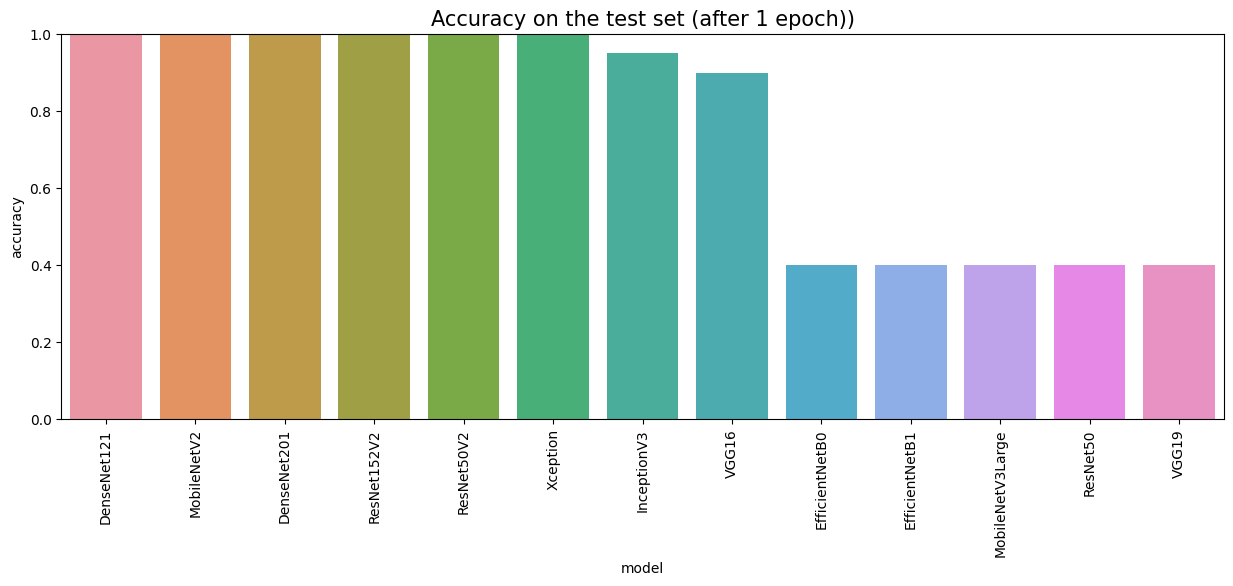

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1) ###
plt.xticks(rotation=90)
plt.show()

In [ ]:

#높은 성능 보인 모델
'''
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
'''


###이미지 분류
